# extract data from the CESM large ensemble and make averages of ecosystem variables in the East and West equatorial Pacific

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m',
             'spNPP_zint100m','diatNPP_zint100m','NPP_zint100m','zoo_prod_zint100m',
             'TEMP_100m_mean','Fe_avg_100m','NO3_100m_mean',
             'PAR_avg_100m'] #'phys_med_Fe','SHF_QSW'

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
Fe_avg_100m
NO3_100m_mean
PAR_avg_100m
CPU times: user 763 ms, sys: 63.9 ms, total: 827 ms
Wall time: 1.45 s


In [3]:
ds.zoo_prod_zint100m

<xarray.DataArray 'zoo_prod_zint100m' (time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<open_dataset-872f5690f251db9261702a7959763627zoo_prod_zint100m, shape=(181, 34, 384, 320), dtype=float64, chunksize=(181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Zooplankton production depth integrated to 100m
    units:         mmol/m^3/s cm
    grid_loc:      3114
    cell_methods:  time: mean

### get pop grid

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')

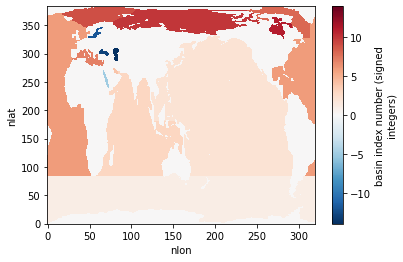

In [5]:
grid.REGION_MASK.plot()

In [6]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [7]:
ds = ds.where(grid.REGION_MASK>0)

### extract one simulation

In [8]:
ds = ds.isel(member_id=0)

### convert rate vars

In [9]:
#converting from mmol/m3 cm/s to g carbon per m^2 per year (gC/m2/y)

ds['NPP_zint100m'] = ds.NPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.NPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['diatNPP_zint100m'] = ds.diatNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.diatNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['spNPP_zint100m'] = ds.spNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.spNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['zoo_prod_zint100m'] = ds.zoo_prod_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.zoo_prod_zint100m.attrs['units'] = 'gC m-2 y-1'

### Define west and east equatorial Pac regions

In [10]:
#box #1, eastern equatorial Pacific
box1_latmin = -7
box1_latmax = 7.
box1_lonmin = -130
box1_lonmax = -100

#box #2, western equatorial Pacific
box2_latmin = -7.
box2_latmax = 7.
box2_lonmin = 140.
box2_lonmax = 175.

### make a quick map of the data

In [11]:
diff_npp = ds.NPP_zint100m.isel(time=slice(170,180)).mean(dim='time') - ds.NPP_zint100m.isel(time=slice(0,10)).mean(dim='time')

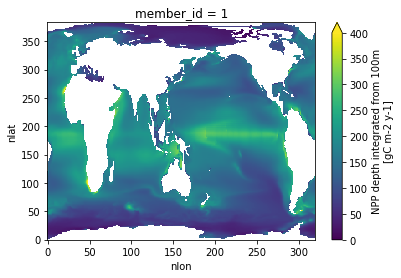

In [21]:
ds.NPP_zint100m.isel(time=slice(0,10)).mean(dim='time').plot(vmin=0,vmax=400)

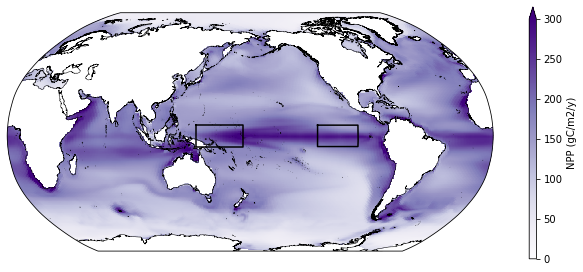

In [25]:
fig = plt.figure(figsize=(10,5))


################################################################################ NPP
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180.0))

#### 
#ax.set_title('a) NPP', fontsize=12)

lon, lat, dat = utils.adjust_pop_grid(lons,lats,ds.NPP_zint100m.isel(time=slice(0,10)).mean(dim='time'))
pc = ax.pcolormesh(lon, lat, dat, vmin=0, vmax=300, cmap = 'Purples',transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5);

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='max',label='NPP (gC/m2/y)');
fig.savefig('/glade/work/kristenk/figs/npp1920s.png', bbox_inches='tight', dpi=300, format='png');

In [ ]:
fig = plt.figure(figsize=(10,5))


################################################################################ NPP
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180.0))

#### 
#ax.set_title('a) NPP', fontsize=12)

lon, lat, dat = utils.adjust_pop_grid(lons,lats,ds.phytoC_zint100m.isel(time=slice(0,10)).mean(dim='time'))
pc = ax.pcolormesh(lon, lat, dat, 
                   vmin=0, vmax=200, 
                   cmap = 'Greens',transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5);

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='max',label='Biomass (mmol/m2)');
fig.savefig('/glade/work/kristenk/figs/biomass1920s.png', bbox_inches='tight', dpi=300, format='png');

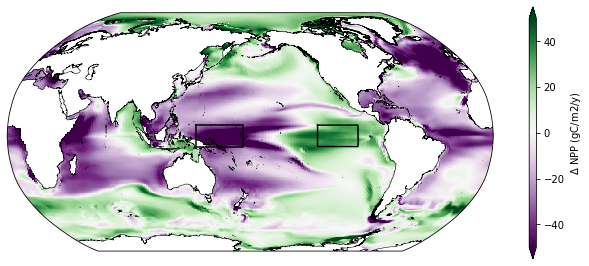

In [16]:
fig = plt.figure(figsize=(10,5))


################################################################################ NPP
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180.0))

#### 
#ax.set_title('a) NPP', fontsize=12)

lon, lat, dat = utils.adjust_pop_grid(lons,lats,diff_npp)
pc = ax.pcolormesh(lon, lat, dat, vmin=-50, vmax=50, cmap = 'PRGn',transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5);

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both',label='${\Delta}$ NPP (gC/m2/y)');
fig.savefig('/glade/work/kristenk/figs/npp_change.png', bbox_inches='tight', dpi=300, format='png');

In [13]:
ds['phytoC_zint100m'] = ds.spC_zint100m + ds.diatC_zint100m

diff_biomass = ds.phytoC_zint100m.isel(time=slice(170,180)).mean(dim='time') - ds.phytoC_zint100m.isel(time=slice(0,10)).mean(dim='time')

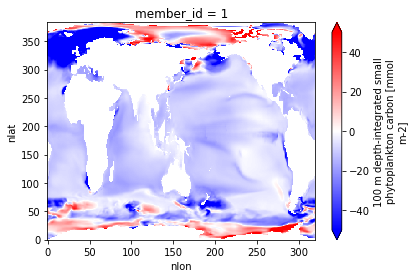

In [14]:
diff_biomass.plot(vmin=-50,vmax=50,cmap='bwr')

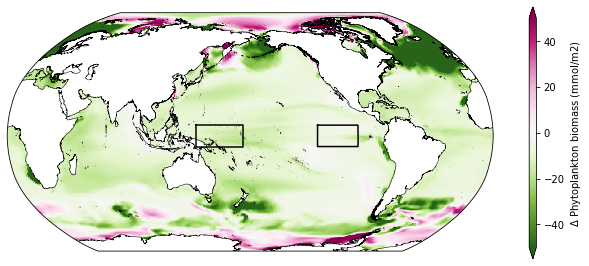

In [18]:
fig = plt.figure(figsize=(10,5))


################################################################################ NPP
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=180.0))

#### 
#ax.set_title('a) NPP', fontsize=12)

lon, lat, dat = utils.adjust_pop_grid(lons,lats,diff_biomass)
pc = ax.pcolormesh(lon, lat, dat, vmin=-50, vmax=50, cmap = 'PiYG_r',transform=ccrs.PlateCarree())

# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5);

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='both',label='${\Delta}$ Phytoplankton biomass (mmol/m2)');

fig.savefig('/glade/work/kristenk/figs/biomass_change.png', bbox_inches='tight', dpi=300, format='png');

In [34]:
lons_norm = utils.normal_lons(lons)

In [15]:
ts_box1 = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds[var].where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    ts_box1[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
Fe_avg_100m
NO3_100m_mean
PAR_avg_100m


In [16]:
ts_box2 = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:
    print(var)
    masked = ds[var].where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    ts_box2[var] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
Fe_avg_100m
NO3_100m_mean
PAR_avg_100m


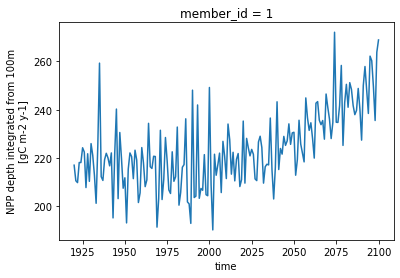

In [17]:
ts_box1.NPP_zint100m.plot()

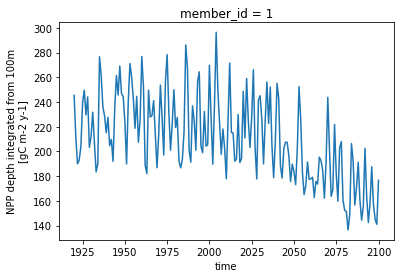

In [18]:
ts_box2.NPP_zint100m.plot()

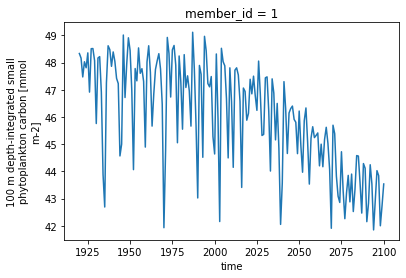

In [19]:
ts_box1.spC_zint100m.plot()

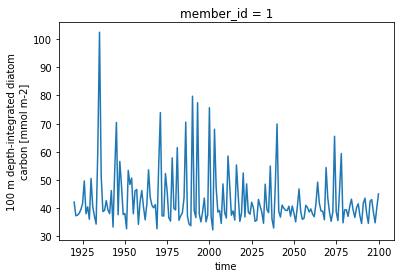

In [20]:
ts_box1.diatC_zint100m.plot()

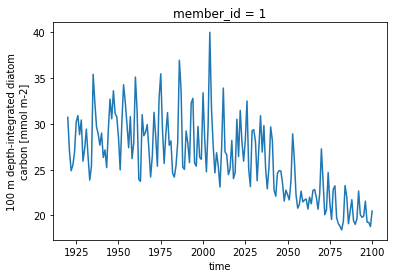

In [21]:
ts_box2.diatC_zint100m.plot()

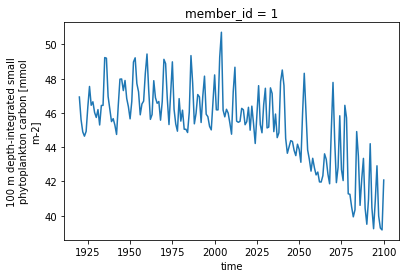

In [22]:
ts_box2.spC_zint100m.plot()

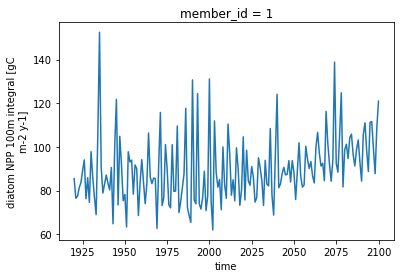

In [23]:
ts_box1.diatNPP_zint100m.plot()

In [24]:
ts_box1.spC_zint100m

<xarray.DataArray 'spC_zint100m' (time: 181)>
array([48.33622541, 48.16772517, 47.47450624, 48.03284411, 47.81124585,
       48.35981412, 46.9164335 , 48.51369359, 48.51895164, 48.07473599,
       45.76124554, 48.17114385, 48.22103535, 46.91499529, 43.89029091,
       42.69114288, 47.2519866 , 48.62082101, 48.47874254, 47.86471308,
       48.39420949, 48.04569515, 47.4230723 , 47.23138552, 44.56912508,
       45.00454535, 49.01615162, 46.71758134, 47.94351032, 48.91419513,
       48.44876497, 46.99031999, 44.06524978, 47.78291854, 47.33111031,
       48.54221142, 47.60840907, 47.77834523, 47.30856276, 44.89436928,
       48.02615174, 48.6214047 , 47.64541243, 45.66609316, 46.84473439,
       47.74907504, 48.06294602, 48.33001393, 47.76414374, 46.47808349,
       41.92971054, 44.77181743, 48.92760326, 48.33832802, 46.73550592,
       48.47132202, 48.63178439, 47.91106295, 45.054191  , 48.24545092,
       47.29509449, 45.55294031, 48.29484183, 47.08711863, 47.51545952,
       46.96421552, 45.66577209, 49.11827962, 47.75583603, 45.70341594,
       43.02372789, 47.89772451, 47.57295427, 44.51902787, 48.96825669,
       48.43893102, 47.23180226, 47.11090273, 47.48897505, 45.2831716 ,
       44.64154675, 48.31937107, 45.93561704, 42.15673132, 48.52827884,
       48.03795114, 47.88599188, 46.67253184, 44.49643483, 47.80903259,
       46.55975744, 44.14998901, 47.72455976, 47.8093713 , 47.54767305,
       46.57944861, 43.41058567, 47.06619859, 46.94175395, 45.88271349,
       46.13496267, 47.3886598 , 46.85260621, 47.5033376 , 46.79617298,
       46.2455399 , 48.05766359, 46.86441617, 45.32066218, 45.3624406 ,
       47.44267401, 47.47721302, 46.22099666, 44.01346454, 47.40378951,
       46.88032355, 45.16012682, 46.50054494, 44.84528585, 42.05104541,
       43.57356273, 47.30154236, 46.30400742, 44.65919198, 46.1500937 ,
       46.31190623, 46.40331937, 45.91388652, 45.8077701 , 44.65360158,
       46.21980672, 44.93875711, 43.96958278, 45.86625009, 46.3340792 ,
       45.06668655, 43.53367033, 45.22190494, 45.64356707, 45.24368798,
       45.32232365, 45.41481926, 44.20464424, 45.00218104, 44.17142405,
       45.172436  , 45.62255192, 45.03108812, 44.07615564, 41.90797974,
       45.69973224, 45.38926341, 43.82834783, 43.09064912, 42.85881375,
       44.72313279, 43.2824123 , 42.26107302, 43.21392608, 43.85409444,
       42.87988256, 43.90214087, 42.52422919, 43.33869381, 44.5820471 ,
       44.56364856, 43.57356491, 42.46755944, 44.28871957, 44.11639055,
       42.15159961, 42.83153026, 44.24530931, 43.540325  , 41.84846253,
       42.94284627, 44.02795547, 43.84361845, 42.00064813, 42.74002474,
       43.53758718])
Coordinates:
    member_id  int64 1
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Attributes:
    long_name:     100 m depth-integrated small phytoplankton carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

In [25]:
ts_box1['year'] = ts_box1.time
ts_box2['year'] = ts_box2.time

In [26]:
df_box1 = ts_box1.to_dataframe()

In [27]:
df_box2 = ts_box2.to_dataframe()

### if we want to make them into CSVs, which can then be imported into Excel, google sheets, etc.

In [28]:
df_box1.to_csv("box1_timeseries.csv", sep=',')
df_box2.to_csv("box2_timeseries.csv", sep=',')

In [29]:
df_box1

,member_id,diatC_zint100m,spC_zint100m,zooC_zint100m,spNPP_zint100m,diatNPP_zint100m,NPP_zint100m,zoo_prod_zint100m,TEMP_100m_mean,Fe_avg_100m,NO3_100m_mean,PAR_avg_100m,year
time,,,,,,,,,,,,,
1920,1,42.150924,48.336225,64.482562,131.437620,85.509943,216.947563,52.992035,22.556991,0.000124,10.337036,22.463482,1920
1921,1,37.306583,48.167725,61.369128,134.012826,76.476257,210.489083,51.035676,23.608330,0.000098,9.381472,22.537205,1921
1922,1,37.518152,47.474506,60.803449,132.220009,77.498327,209.718335,50.754703,23.768003,0.000104,9.266888,22.154856,1922
1923,1,38.186065,48.032844,62.134344,136.783173,81.275987,218.059160,53.020723,23.788133,0.000107,9.067880,22.545488,1923
1924,1,39.544998,47.811246,63.207090,134.440956,83.608842,218.049798,53.225264,23.207025,0.000120,9.569954,22.223841,1924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,1,43.040384,44.027955,63.451629,148.697656,111.617971,260.315628,64.378863,24.539114,0.000177,9.359763,20.704206,2096
2097,1,38.534912,43.843618,59.245834,150.178061,99.225287,249.403348,60.722880,26.170848,0.000133,7.718767,21.010016,2097
2098,1,34.807529,42.000648,54.054359,147.750438,87.758350,235.508788,56.162773,27.786921,0.000123,5.462729,20.370930,2098


In [30]:
df_box1.columns

Index(['member_id', 'diatC_zint100m', 'spC_zint100m', 'zooC_zint100m',
       'spNPP_zint100m', 'diatNPP_zint100m', 'NPP_zint100m',
       'zoo_prod_zint100m', 'TEMP_100m_mean', 'Fe_avg_100m', 'NO3_100m_mean',
       'PAR_avg_100m', 'year'],
      dtype='object')

### take the trend of box1 diatom NPP

In [31]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_box1.year,df_box1.diatNPP_zint100m)

In [32]:
slope

0.08098659205783879

In [33]:
p_value

0.00011930995919444564

In [34]:
model_diatNPP = np.empty(len(df_box1.year))
i=0
for yr in df_box1.year:
    model_diatNPP[i] = slope * yr + intercept
    i = i + 1

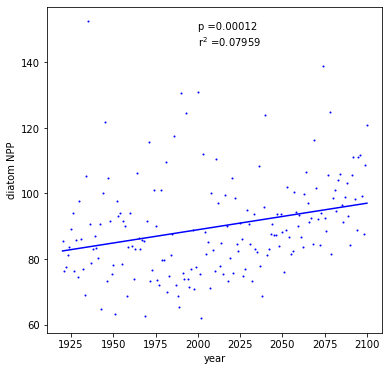

In [35]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(df_box1.year,model_diatNPP,color='blue')
ax.set(xlabel='year',ylabel='diatom NPP')
ax.scatter(df_box1.year,df_box1.diatNPP_zint100m,marker='o',s=1,color='blue');
ax.annotate("p =" + str(np.round(p_value,5)), (2000, 150))
ax.annotate("r$^2$ =" + str(np.round(r_value**2,5)), (2000, 145));

##### a p value < 0.05 means that the trend is statistically significant
##### a low r$^{2}$ (like < 0.1) means that there is a lot of scatter

### Now let's do a correlation - it's the same process but we interpret it differently
### try a correlation between diatNPP and spNPP in box1

In [36]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_box1.Fe_avg_100m,df_box1.diatNPP_zint100m)

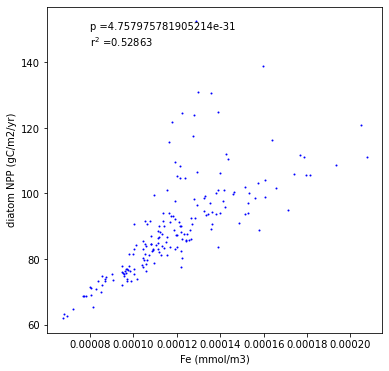

In [40]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel='Fe (mmol/m3)',ylabel='diatom NPP (gC/m2/yr)')
ax.scatter(df_box1.Fe_avg_100m,df_box1.diatNPP_zint100m,marker='o',s=1,color='blue');
ax.annotate("p =" + str(p_value), (0.00008, 150))
ax.annotate("r$^2$ =" + str(np.round(r_value**2,5)), (0.00008, 145));

In [41]:
r_value

0.7270668730964427

In [42]:
p_value

4.757975781905214e-31

In [43]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_box1.Fe_avg_100m,df_box1.NPP_zint100m)

In [44]:
r_value

0.8060100823084694

In [45]:
p_value

1.258843947361373e-42

In [46]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_box1.Fe_avg_100m,df_box1.spNPP_zint100m)

In [47]:
r_value

0.22949538106328854

In [48]:
p_value

0.0018852405933232745